20211102_S2B3R3E-f_ref
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


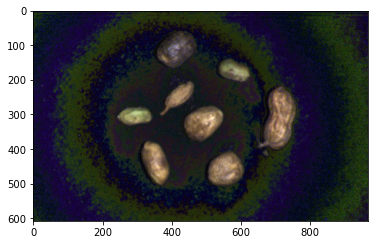

In [3]:
#%%
from scipy.signal import medfilt
from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
from PIL import Image
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from skimage import measure
from sklearn.utils import resample
from scipy import spatial
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance
from pathlib                 import Path
import glob


plt.close('all')
path = glob.glob(r'./Train_Data/HSI_Data/*')
filename=path[0][path[0].rfind('\\')+1:]
print(filename)
img_rgb = Image.open(os.path.join(path[0], filename+'.png')).convert('RGB')
img_rgb_ar = np.array(img_rgb)
view_rgb = imshow(img_rgb_ar)
hsi_ref = envi.open(os.path.join(path[0], filename+'.hdr'),\
                      os.path.join(path[0], filename+'.dat'))
hsi_np = hsi_ref.asarray()
Mask = np.load('./Train_Data/Valid_Mask/'+filename+'.npy')
print(Mask.astype(int))

In [4]:
#%% filtering the peanut spectra with 1x5 convolutional filter
row,col = np.where(Mask==1)
hsi_p=hsi_np[row,col]
hsi_filtered=np.zeros((len(hsi_p),299))

rand_np = np.copy(hsi_np)
for i in range(len(hsi_p)):
    rand_np[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)

In [5]:
#%% Normalize the peanut spectra
for i in range(len(row)):
    rand_np[row[i],col[i]]=(rand_np[row[i],col[i]]-min(rand_np[row[i],col[i]]))/(max(rand_np[row[i],col[i]])-min(rand_np[row[i],col[i]]))


In [6]:
all_peanut_pixels=rand_np[row,col]
all_peanut_pixels.T.shape

(299, 46169)

 
Change in Objective Function Value: inf
Minimum of Maximum Proportions: 0.9999999999999553
Number of Endmembers: 20
Iteration: 1
 
 
Change in Objective Function Value: 11.524599896111624
Minimum of Maximum Proportions: 6.123441765874033e-15
Number of Endmembers: 19
Iteration: 2
 
 
Change in Objective Function Value: 57.6025140982652
Minimum of Maximum Proportions: 0.0
Number of Endmembers: 15
Iteration: 3
 
 
Change in Objective Function Value: 60.67828656328177
Minimum of Maximum Proportions: 5.763651670099616e-15
Number of Endmembers: 11
Iteration: 4
 
 
Change in Objective Function Value: 15.24297110760088
Minimum of Maximum Proportions: 0.0
Number of Endmembers: 10
Iteration: 5
 
 
Change in Objective Function Value: 15.758891993154151
Minimum of Maximum Proportions: 9.312837315153261e-10
Number of Endmembers: 9
Iteration: 6
 
 
Change in Objective Function Value: 0.25948416892163095
Minimum of Maximum Proportions: 0.7072593521836885
Number of Endmembers: 9
Iteration: 7
 
 
Cha

Text(0.5, 1.0, 'SPICE Endmembers')

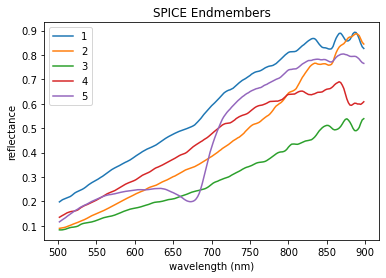

In [7]:
#%%
from Model import *
import matplotlib.pyplot as plt


# def main():

# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20] 

# get the default parameters from the SPICE.py file
params = SPICEParameters()
params.qp_solver = 'QPP'
params.gamma=10
params.u=0.1
# run the spice algorithm on the down sampled data
[endmembers, ds_proportions] = SPICE(ds_data, params)

# prompt the user to see if they would like to graph the output
# if input('Would you like to plot the output? (Y/n): ') == 'n':
#     return

# plot the wavelength versus the reflectance
n_em = endmembers.shape[1]
plt.plot(x_ax, endmembers)
plt.xlabel('wavelength (nm)')
plt.ylabel('reflectance')
plt.legend([str(i + 1) for i in range(n_em)])
plt.title('SPICE Endmembers')

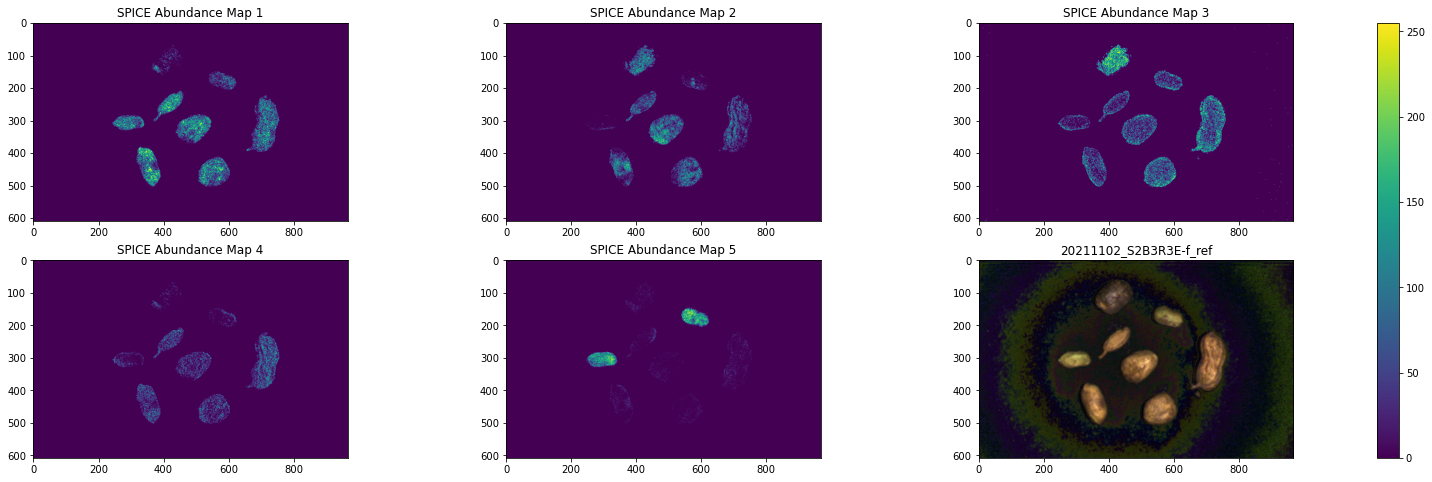

In [8]:
#%%

#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 10:58:03 2020

@author: weihuang
"""
# load the data from the pickle file

valid_mask=Mask.astype(bool)
# trim the noisy bands
hsi_image = rand_np[:,:,50:-50]
x_ax=np.linspace(402,998,299)
x_ax=x_ax[50:-50]
img_shape = hsi_image.shape
n_r, n_c, n_b = hsi_image.shape

# load the wavelength information

# reshape the data because SPICE takes an MxN array, not a full HSI cube
hsi_image = np.reshape(hsi_image, (img_shape[0]*img_shape[1], img_shape[2]))
valid_array = np.reshape(valid_mask, (img_shape[0]*img_shape[1],))
# take the hsi data at the "valid" points
M = hsi_image[valid_array, :]

# since analyzing the image will take a long time, we will down sample the data for the sake of this demo
input_data = M.T.astype(float)
ds_data = input_data[:, ::20]

# unmix the data using the non-downsampled array and the endmembers that SPICE discovered


if params.qp_solver == 'cvxopt':
    P = unmix_cvxopt(input_data, endmembers)
else:
    scaler = input_data.max()
    P = unmix_qpp(input_data/scaler,endmembers/scaler)

# re-ravel abundance maps
P_imgs = []
for i in range(n_em):
    map_lin = np.zeros((n_r * n_c,))
    map_lin[valid_array] = P[:, i]
    P_imgs.append(np.reshape(map_lin, (n_r, n_c)))

# display abundance maps in the form of a subplot

fig, axes = plt.subplots(2, int(n_em/2) + 1, squeeze=True,figsize=(30,8))

for i in range(n_em):
    im = axes.flat[i].imshow(P_imgs[i], vmin=0, vmax=1)
    axes.flat[i].set_title('SPICE Abundance Map %d' % (i + 1))

# add the original RGB image to the subplot
im = axes.flat[n_em].imshow(img_rgb_ar)
axes.flat[n_em].set_title(filename)
fig.colorbar(im, ax=axes.ravel().tolist())

# delete any empty subplots
if (n_em % 2 == 0):
    fig.delaxes(axes.flatten()[(2*(int(n_em/2)+1)) -1])
# plt.savefig(filename+'.jpg')
plt.show()


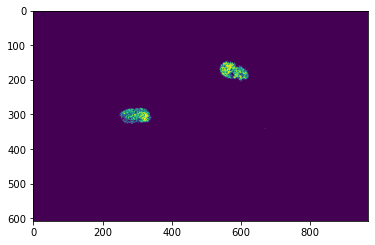

In [9]:
p1=np.copy(P_imgs[4])
p1[p1>=0.5]=1
p1[p1<0.5]=0
plt.imshow(p1)
# p2=np.copy(P_imgs[2])
# p2[p2>=0.5]=1
# p2[p2<0.5]=0
# plt.imshow(p2)
p=p1
plt.imshow(p)

In [10]:
r_p,c_p=np.where(p==1)
pb=rand_np[r_p,c_p]
np.shape(pb)

(3531, 299)

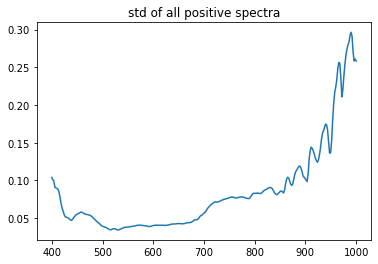

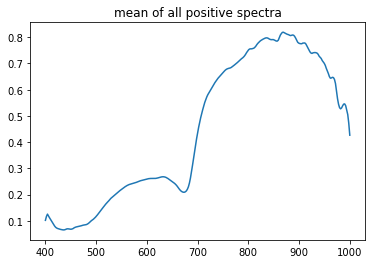

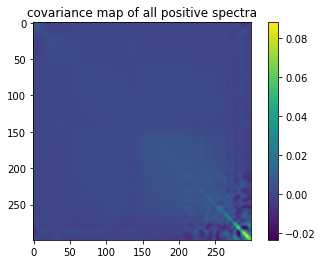

In [11]:
plt.plot(np.linspace(400,1000,len(np.std(pb,axis=0))),np.std(pb,axis=0))
plt.title('std of all positive spectra')
plt.show()
plt.plot(np.linspace(400,1000,len(np.mean(pb,axis=0))),np.mean(pb,axis=0))
plt.title('mean of all positive spectra')
plt.show()
plt.imshow(np.cov(pb.T))
plt.colorbar()
plt.title('covariance map of all positive spectra')
plt.show()

In [12]:
positive_bags=np.array_split(pb[0:3408],200)
np.shape(positive_bags)

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(200,)

In [70]:
means_pos_bag=np.zeros((200,299))
for i in range(len(positive_bags)):
    means_pos_bag[i,:]=np.mean(positive_bags[i],axis=0)

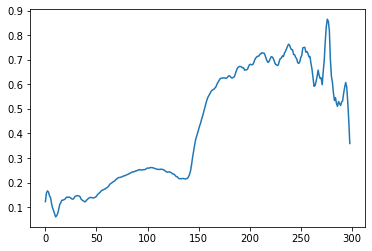

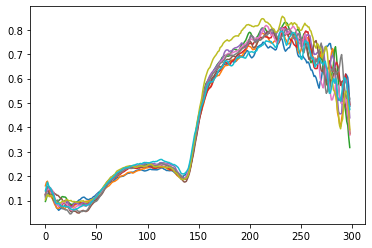

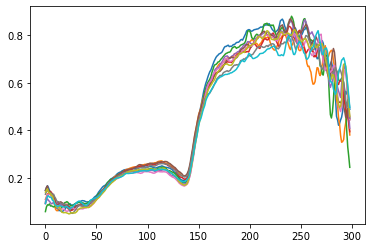

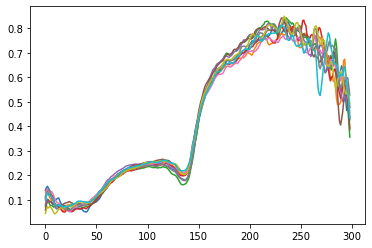

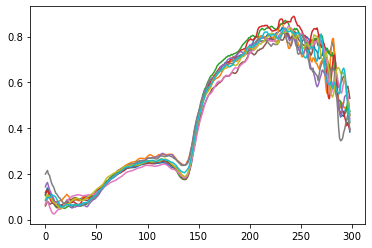

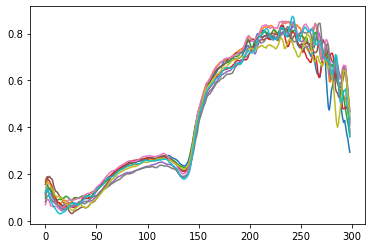

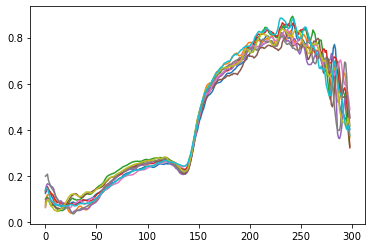

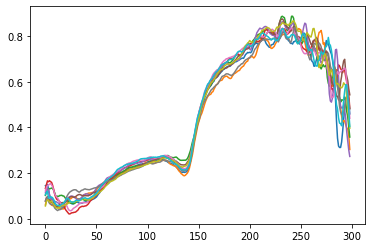

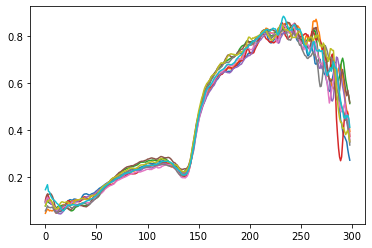

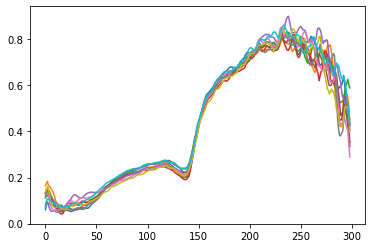

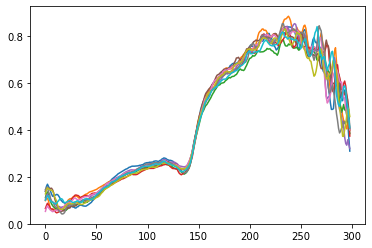

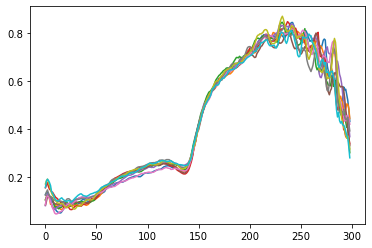

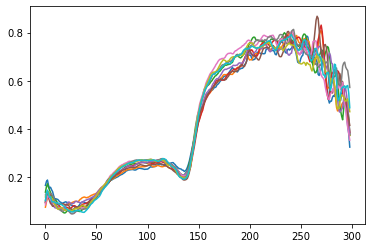

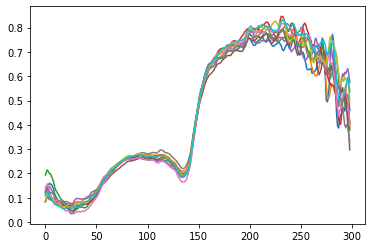

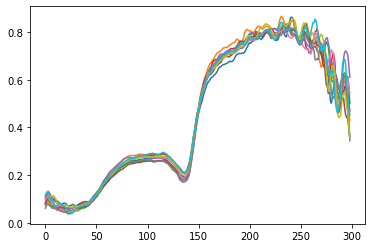

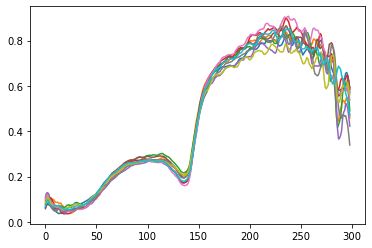

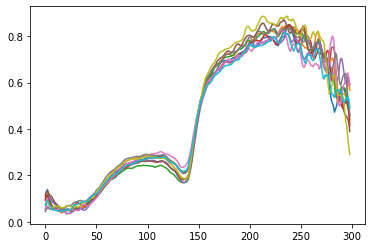

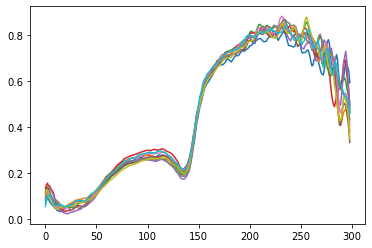

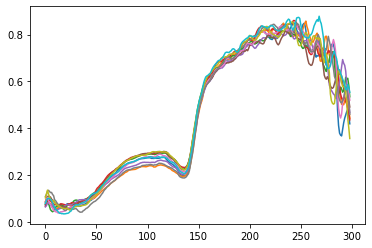

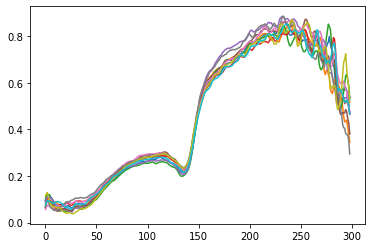

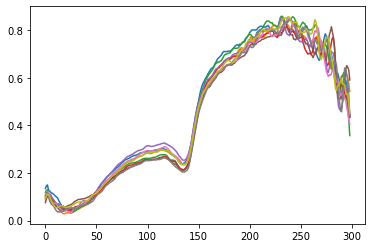

In [75]:
for i in range(len(positive_bags)):
    plt.plot(np.mean(positive_bags[i],axis=0))
    if (i%10==0):
        plt.show()

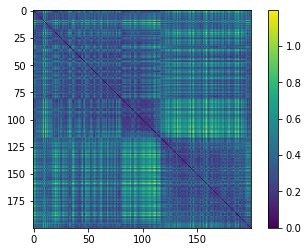

In [77]:
plt.imshow(sklearn.metrics.pairwise_distances(means_pos_bag[:,50:-70],metric='euclidean'))
plt.colorbar()
plt.show()

(31541, 299)

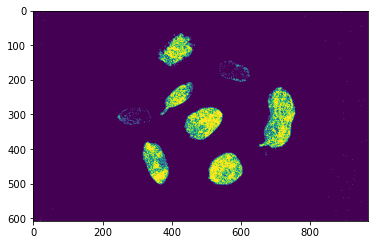

In [13]:
neg=P_imgs[0]+P_imgs[1]+P_imgs[2]+P_imgs[3]
neg[neg>=0.999999]=1
neg[neg<0.999999]=0
plt.imshow(neg)
r_n,c_n=np.where(neg==1)
nb=rand_np[r_n,c_n]
np.shape(nb)

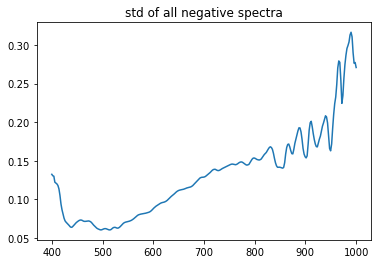

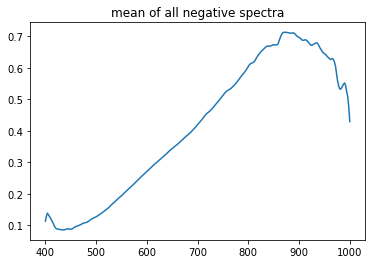

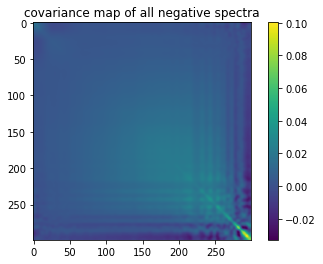

In [14]:
plt.plot(np.linspace(400,1000,len(np.std(nb,axis=0))),np.std(nb,axis=0))
plt.title('std of all negative spectra')
plt.show()
plt.plot(np.linspace(400,1000,len(np.mean(nb,axis=0))),np.mean(nb,axis=0))
plt.title('mean of all negative spectra')
plt.show()
plt.imshow(np.cov(nb.T))
plt.colorbar()
plt.title('covariance map of all negative spectra')
plt.show()

In [51]:
negative_bags=np.array_split(nb[15000:22001],200)
np.shape(negative_bags)

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(200,)

In [52]:
means_neg_bag=np.zeros((200,299))
for i in range(len(negative_bags)):
    means_neg_bag[i,:]=np.mean(negative_bags[i],axis=0)

In [ ]:
from scipy.spatial import distance_matrix

distance_matrix(nb, nb)

In [16]:
import sklearn.metrics.pairwise
dists = sklearn.metrics.pairwise.manhattan_distances(nb[0:7001])

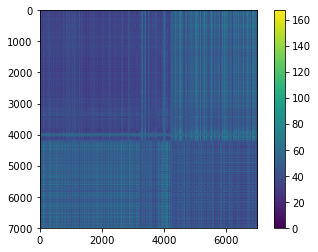

In [17]:
plt.imshow(dists)
plt.colorbar()

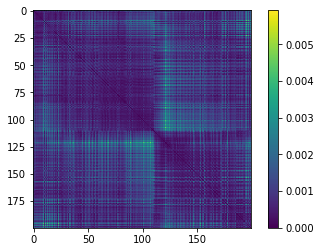

In [71]:
plt.imshow(sklearn.metrics.pairwise_distances(means_neg_bag[:,50:-70],metric='cosine'))
plt.colorbar()
plt.show()

In [56]:
bags=np.array([])
bags=np.append(bags,np.asarray(positive_bags))
bags=np.append(bags,np.asarray(negative_bags))
np.shape(bags)

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(400,)

In [57]:
labels=np.zeros((1,400))

labels[0,0:200]=1

In [58]:
labels_test=Mask
labels_test[r_n,c_n]=0
labels_test=np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1],))
labels_test.shape

(588544,)

------------ Spectral Matched Filter -------------
Whitening...
Initializing with exhaustive_init...
Optimizing...
Detecting SMF...
------------ Adaptive Cosine Estimator -------------
Whitening...
Initializing with exhaustive_init...


c:\Users\k.hamad\Desktop\UF\PhD\Codes\Detection\miace\mi_target.py:233: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  denom = np.array([np.reshape(denom[bag], (denom[bag].shape[0], 1)) for bag in range(m_scale.shape[0])])


Optimizing...
Detecting ACE...

Plotting Target Concept and ROC Curve...


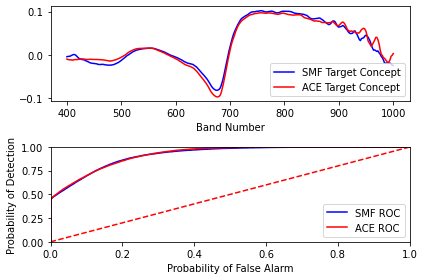

In [59]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from miace.detectors import ace_det, smf_det
from miace.mi_target import mi_target

results = {'smf': {}, 'ace': {}}

parameters = {
    "global_background_flag": False,
    "pos_label": 1,
    "neg_label": 0,
    "max_iter": 100,
    "init_type": 1,
	"init_k": 1000
}

example_data = np.load('datasets/simple_example_data.npz')

# to accomodate bags of difference sizes
bag_list = [example_data['data_bags'][i] for i in range(example_data['data_bags'].shape[0])]

#to test whether the methods work on different sizes. combining a few bags together to create uneven bags
bag_list[0] = np.vstack((bag_list[0], bag_list[1]))
bag_list.pop(1)
labels = np.delete(example_data['labels'], 1, 1)

# SMF init1
print('------------ Spectral Matched Filter -------------')
parameters['method_flag'] = False
parameters['sample_por'] = 1
labels=np.zeros((1,400))
labels[0,0:200]=1
# smf_opt_target, _, b_mu, sig_inv_half, _ = mi_target(
#     example_data['data_bags'], example_data['labels'], parameters)

smf_opt_target, _, b_mu, sig_inv_half, _ = mi_target(np.asarray(bags), labels, parameters)

print('Detecting SMF...')
# smf_data, _, _ = smf_det(example_data['x_test'], smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
smf_data, _, _ = smf_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
# ACE init 1
print('------------ Adaptive Cosine Estimator -------------')
parameters['method_flag'] = True
parameters['sample_por'] = 1

# ace_opt_target, _, b_mu, sig_inv_half, _ = mi_target(
#     example_data['data_bags'], example_data['labels'], parameters)

ace_opt_target, _, b_mu, sig_inv_half, _ = mi_target(np.asarray(bags), labels, parameters)

print('Detecting ACE...')
# ace_data, _, _ = ace_det(example_data['x_test'], ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
ace_data, _, _ = ace_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))

print('\nPlotting Target Concept and ROC Curve...')

# Get false and true positive rate
# labels_point_test = example_data['labels_point_test']
labels_point_test = labels_test

smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)


f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

# Target Concept
ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
ax1.legend(loc='lower right')
ax1.set_xlabel('Band Number')

# ROC
ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.legend(loc='lower right')
ax2.set_xlabel('Probability of False Alarm')
ax2.set_ylabel('Probability of Detection')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

Detecting SMF...
Detecting ACE...


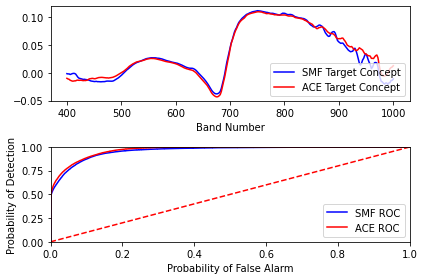

In [551]:
print('Detecting SMF...')
# smf_data, _, _ = smf_det(example_data['x_test'], smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
smf_data, _, _ = smf_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
print('Detecting ACE...')
# ace_data, _, _ = ace_det(example_data['x_test'], ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
ace_data, _, _ = ace_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
labels_point_test = labels_test

smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)


f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

# Target Concept
ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
ax1.legend(loc='lower right')
ax1.set_xlabel('Band Number')

# ROC
ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.legend(loc='lower right')
ax2.set_xlabel('Probability of False Alarm')
ax2.set_ylabel('Probability of Detection')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('train ROC')
plt.show()



In [60]:
ace_data=np.reshape(ace_data,(608,968))

In [61]:
smf_data=np.reshape(smf_data,(608,968))

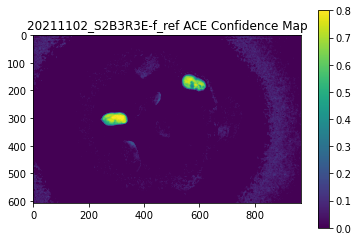

In [65]:
plt.imshow(ace_data,vmin=0, vmax=0.8)
plt.title('20211102_S2B3R3E-f_ref ACE Confidence Map')
plt.colorbar()
plt.savefig('train ACE')

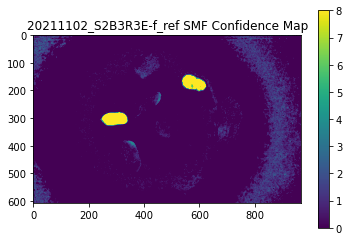

In [67]:
plt.imshow(smf_data,vmin=0, vmax=8)
plt.title('20211102_S2B3R3E-f_ref SMF Confidence Map')
plt.colorbar()
plt.savefig('train SMF')

In [475]:
smf_data.reshape(smf_data.shape[0]*smf_data.shape[1])

array([-1.31947344, -1.31766839, -0.10139035, ..., -0.46112271,
       -1.54954483, -0.41122697])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

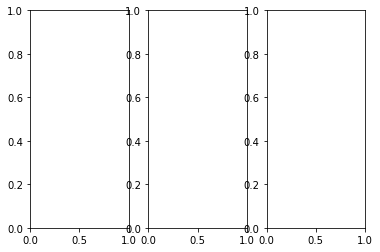

In [607]:
# fig = plt.figure(figsize=(30, 6))
# fig.suptitle('hi')
# ax1 = fig.add_subplot(131)
# ax.pcolormesh(smf_data,cmap='viridis')
# cax = divider.append_axes('right', size='5%', pad=0.05)
# ax.set_title('ROC')
# ax = fig.add_subplot(132)
# ax.pcolormesh(smf_data,vmin=0, vmax=1,cmap='viridis')
# ax.set_title('ACE')
# ax = fig.add_subplot(133)
# ax.pcolormesh(smf_data,vmin=0, vmax=1,cmap='viridis')
# ax.set_title('SMF')


fig, ax = plt.subplots(1, 3)
for i in range(2):
    for j in range(2):
         data = np.array([[i, j], [i+0.5, j+0.5]])
         im = ax[i, j].imshow(smf_data)
         plt.colorbar(im, ax=ax[i, j])

plt.show()
# fig.colorbar(cmap='viridis',ax=ax)

# plt.subplot(1,3,1)
# plt.imshow(smf_data, vmin=0, vmax=8,figsize=(10,10))
# plt.subplot(1,3,2)
# plt.imshow(smf_data, vmin=0, vmax=8)

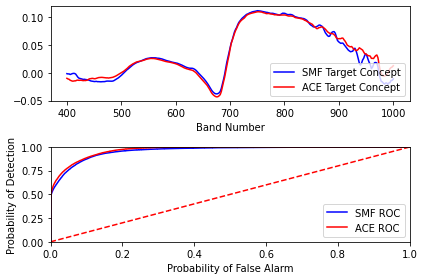

TypeError: float() argument must be a string or a number, not 'AxesSubplot'

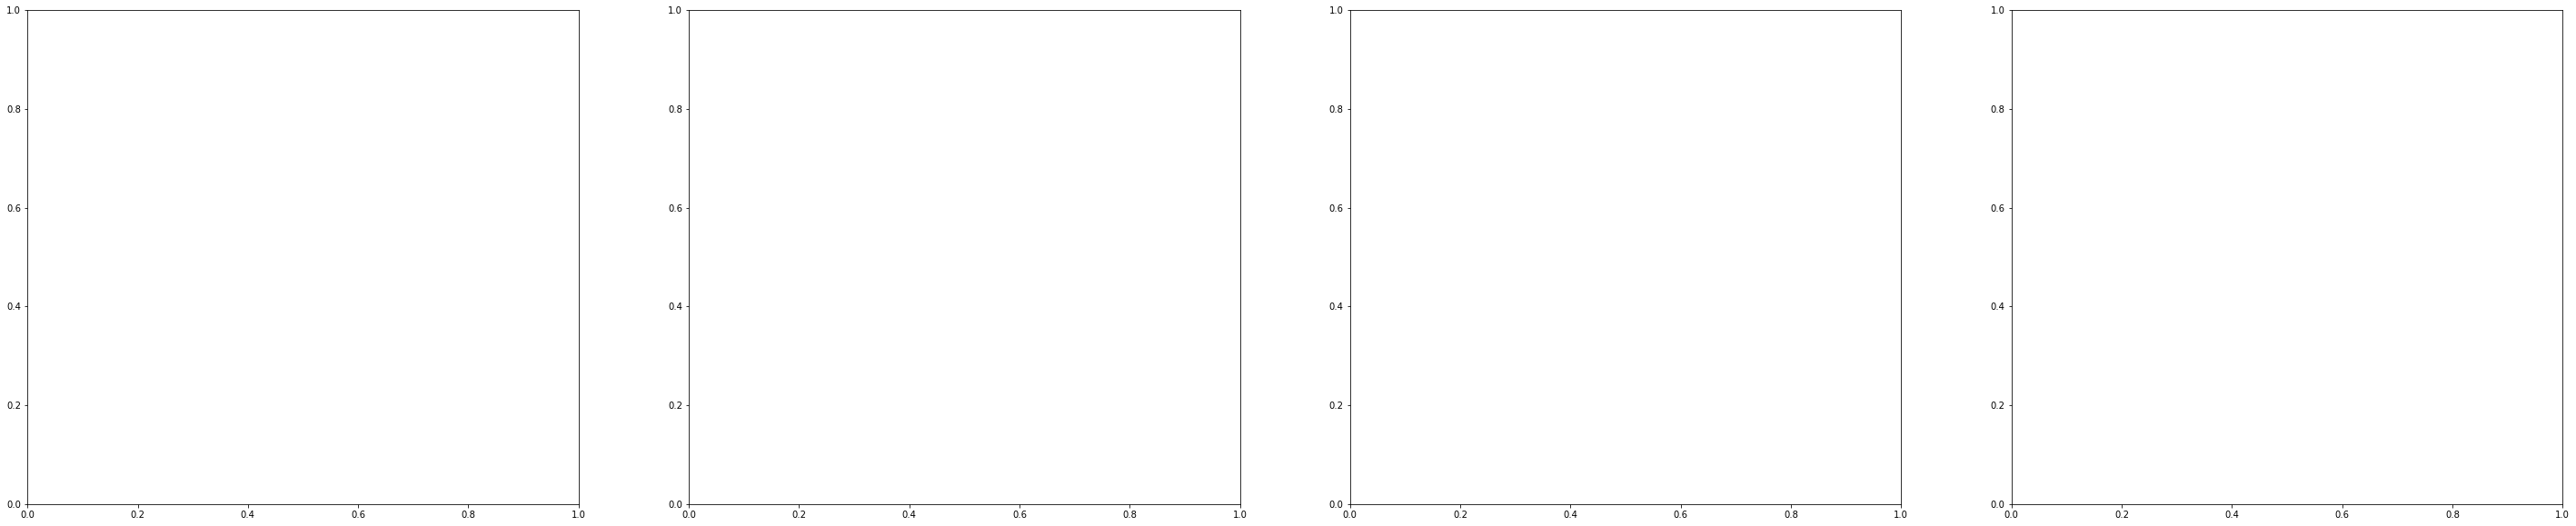

In [627]:
f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

# Target Concept
ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
ax1.legend(loc='lower right')
ax1.set_xlabel('Band Number')

# ROC
ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
ax2.plot([0, 1], [0, 1], 'r--')
ax2.legend(loc='lower right')
ax2.set_xlabel('Probability of False Alarm')
ax2.set_ylabel('Probability of Detection')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('train ROC')
plt.show()

fig, ax = plt.subplots(1, 4,figsize=(50,10),squeeze=True)
im = ax[0].plot(ax1)

im = ax[1].imshow(smf_data,vmin=0, vmax=8)
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(smf_data,vmin=0, vmax=8)
plt.colorbar(im, ax=ax[2])
im = ax[3].imshow(smf_data,vmin=0, vmax=8)
plt.colorbar(im, ax=ax[3])
plt.tight_layout()
plt.savefig('bingo')

In [640]:
np.save(r'./smf_opt_target_E1.npy',smf_opt_target)
np.save(r'./ace_opt_target_E1.npy',ace_opt_target)

In [68]:
np.max(smf_data)

27.044600067961188

-0.3310910288917625
0.7486764714176372
-6.06722823264668
16.55035108442508


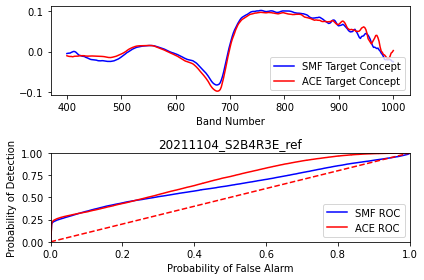

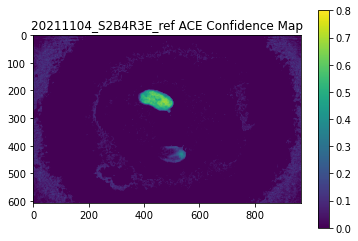

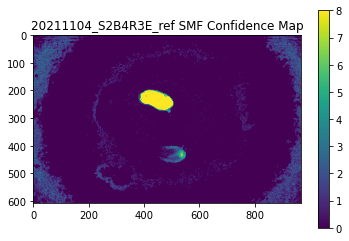

C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


KeyboardInterrupt: 

In [79]:
pathse=glob.glob(r'U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\*')
count=1

#import wandb


# wandb.init(project="Detection", entity="knhamad",name=filename)

count=1
for i in pathse:
    # if (count==9):
    #     break
    filename=i[i.rfind('\\')+1:]
    if(filename!='20211109_S2B4R2W_ref' and
     filename!='20211109_S2B4R2W_4_ref' and
      filename!='20211109_S2B4R2W_3_ref' and
       filename!='20211109_S2B4R2W_2_ref' and
        filename!='20211109_S2B4R2E-f_3_ref' and
         filename!='20211109_S2B3R2E_4_ref'and
          filename!='20211109_S2B3R2E-f_ref'and
           filename!='20211109_S2B3R2E-f_4_ref'and
            filename!='20211104_S2B4R3E_ref'):
        continue
    # wandb.init(project="Detection", entity="knhamad",name=filename)
    hsi_ref = envi.open(os.path.join(i,filename+'.hdr'),\
                          os.path.join(i,filename+'.dat'))
    hsi_np = hsi_ref.asarray()
    Mask = np.load(os.path.join(r'U:\AT\Data\lab_HSI\Greenhouse_202111\Masks',filename+'.npy'))
 
    #%% filtering the peanut spectra with 1x5 convolutional filter
    row,col = np.where(Mask==1)
    hsi_p=hsi_np[row,col]
    hsi_filtered=np.zeros((len(hsi_p),299))

    rand_np = np.copy(hsi_np)
    for i in range(len(hsi_p)):
        rand_np[row[i],col[i]] = medfilt(hsi_np[row[i],col[i]],5)
    #%% Normalize the peanut spectra
    for i in range(len(row)):
        rand_np[row[i],col[i]]=(rand_np[row[i],col[i]]-min(rand_np[row[i],col[i]]))/(max(rand_np[row[i],col[i]])-min(rand_np[row[i],col[i]]))
    labels_test=Mask
    labels_test[r_n,c_n]=0
    labels_test=np.reshape(labels_test, (labels_test.shape[0]*labels_test.shape[1],))
    labels_test.shape
    
    smf_data, _, _ = smf_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, smf_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
    ace_data, _, _ = ace_det(np.reshape(rand_np,(rand_np.shape[0]*rand_np.shape[1],rand_np.shape[2])).T, ace_opt_target.T, b_mu, np.matmul(sig_inv_half.T, sig_inv_half))
    labels_point_test = labels_test

    smf_fpr, smf_tpr, smf_threshold = roc_curve(labels_point_test, smf_data, pos_label=1)
    ace_fpr, ace_tpr, ace_threshold = roc_curve(labels_point_test, ace_data, pos_label=1)
    data=np.zeros((len(smf_tpr),2))
    data[:,1]=smf_tpr
    data[:,0]=smf_fpr

    # table = wandb.Table(data=data, columns = ["smf_fpr", "smf_tpr"])
    # wandb.log({"ROC_curve" : wandb.plot.line(table, "smf_fpr", 
    #        "smf_tpr", stroke=None, title="ROC")})
    # table = wandb.Table(data=data, columns = ["smf_fpr", "smf_tpr"])
    # wandb.log({"ROC_curve" : wandb.plot.line(table=data,x=smf_tpr,y=smf_fpr, title="ROC")})
    



    f, (ax1, ax2) = plt.subplots(2, sharex=False, sharey=False)

    # Target Concept
    ax1.plot(np.linspace(400,1000,len(smf_opt_target)),smf_opt_target, 'b', label='SMF Target Concept')
    ax1.plot(np.linspace(400,1000,len(ace_opt_target)),ace_opt_target, 'r', label='ACE Target Concept')
    ax1.legend(loc='lower right')
    ax1.set_xlabel('Band Number')

    
    # ROC
    ax2.plot(smf_fpr, smf_tpr, 'b', label='SMF ROC')
    ax2.plot(ace_fpr, ace_tpr, 'r', label='ACE ROC')
    ax2.plot([0, 1], [0, 1], 'r--')
    ax2.legend(loc='lower right')
    ax2.set_xlabel('Probability of False Alarm')
    ax2.set_ylabel('Probability of Detection')
    ax2.set_title(filename)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    print(np.min(ace_data))
    print(np.max(ace_data))
    print(np.min(smf_data))
    print(np.max(smf_data))
    plt.tight_layout()
    # wandb.log({"ROC":wandb.Image(f)})
    plt.show()
    count+=1

    ace_data=np.reshape(ace_data,(608,968))
    plt.imshow(ace_data,vmin=0, vmax=0.8)
    plt.title(filename+' ACE Confidence Map')
    plt.colorbar()
    plt.show()

    smf_data=np.reshape(smf_data,(608,968))
    plt.imshow(smf_data,vmin=0, vmax=8)
    plt.title(filename+' SMF Confidence Map')
    plt.colorbar()
    plt.show()
    # run_name = filename
    # run_object = wandb.init(name = run_name, project="Detection", entity="knhamad")
    #run_name = filename
    #run_object = wandb.init(name = run_name, project="Detection", entity="knhamad")
    #dataa = [[x, y] for (x, y) in zip(data[::8,0], data[::8,1])]
    #table = wandb.Table(data=dataa, columns = ["False Positive Rate", "True Positive Rate"])
    #wandb.log({"run1" : wandb.plot.line(table, "False Positive Rate", 
    #        "True Positive Rate", stroke=None, title="ROC Curve")})
#run_object.finish()

In [306]:
ace_data=np.reshape(ace_data,ace_data.shape[0]*ace_data.shape[1])

IndexError: tuple index out of range

In [313]:
cp=np.copy(ace_data)

In [308]:
cp=(cp-min(cp))/(max(cp)-min(cp))

In [314]:
cp[cp<0]=0
cp[cp>0]=1


In [311]:
cp=np.reshape(cp,(608,968))

TypeError: Invalid shape (588544,) for image data

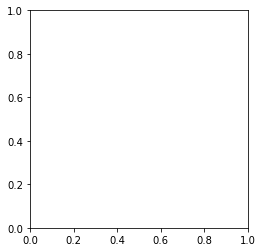

In [315]:
plt.imshow(cp)

In [23]:

print(data[:,0].shape)
print(data[:,1].shape)
run_name = "let him see again"
run_object = wandb.init(name = run_name, project="Detection", entity="knhamad")

dataa = [[x, y] for (x, y) in zip(data[::8,0], data[::8,1])]
table = wandb.Table(data=dataa, columns = ["Wavelngths (nm)", "Normalized Reflectance Spectra"])
wandb.log({"Reflectance_spectra" : wandb.plot.line(table, "Wavelngths (nm)", 
           "Normalized Reflectance Spectra", stroke=None, title="Visualizing Reflectance spectra")})
run_object.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


(43292,)
(43292,)


wandb: Currently logged in as: knhamad (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


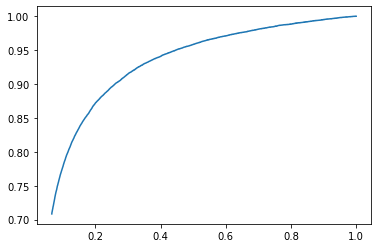

In [37]:
data = np.array(data)
plt.plot(data[:,0], data[:,1])


In [32]:
fig,ax=plt.subplots()
ax.plot(data[:,0],data[:,1])
wandb.init(project="Detection", entity="knhamad")
wandb.run.name=wandb.run.id
wandb.log({"ROC":fig})


wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\wandb\sdk\wandb_run.py", line 1805, in _atexit_cleanup
    self._on_finish()
  File "C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\wandb\sdk\wandb_run.py", line 1951, in _on_finish
    self.history._flush()
  File "C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\wandb\sdk\wandb_history.py", line 59, in _flush
    self._callback(row=self._data, step=self._step)
  File "C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\wandb\sdk\wandb_run.py", line 1028, in _history_callback
    row, step, publish_step=not_using_tensorboard
  File "C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\wandb\sdk\interface\interface.py", line 496, in publish_history
    data = data_types.history_dict_to_json(run, data, step=step)
  File "C:\ProgramData\Anaconda3\envs\spice_env\lib\site-packages\wandb\sdk\data_types.py", line 2591, in histo

wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KD410~1.HAM\\AppData\\Local\\Temp\\tmpxu80yar_wandb-media\\3fhi5nm5.plotly.json'

In [1]:
!pip install plotly

In [116]:
print(os.path.join(i,filename+'.hdr'))

U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\20211102_S1B1R1E-f_2_ref\20211102_S1B1R1E-f_2_ref.hdr


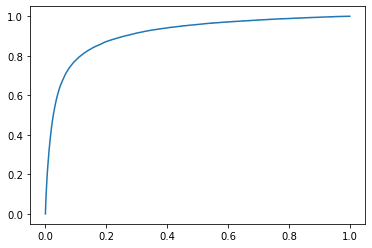

In [41]:
plt.plot(data[:,0],data[:,1])

In [ ]:
pathse=glob.glob(r'U:\AT\Data\lab_HSI\Greenhouse_202111\Reflectance folders\*')
print(pathse)

In [1]:
!wandb logout

Usage: wandb [OPTIONS] COMMAND [ARGS]...
Try 'wandb --help' for help.

Error: No such command 'logout'.
